In [1]:
import os
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from PIL import Image

from sonnmf.main import sonnmf
from sonnmf.utils import calculate_gscore

In [2]:
def save_results(filepath, W, H, fscores, gscores, hscores, total_scores):
    with open(filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H, fscores=fscores, gscores=gscores, hscores=hscores, total_scores=total_scores)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

In [3]:
def plot_separate_H(H, img_size, figsize, fontsize, num_rows=4, normalize_row=False, filename=None):
    rank = H.shape[0]
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    num_cols = int(np.ceil(rank / num_rows))
    if num_rows > 1:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
        cnt = 0
        for i in range(num_rows):
            for j in range(num_cols):
                if cnt < rank:
                    img = axs[i, j].imshow(H3d[cnt, :, :], cmap='gray')
                    axs[i, j].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
                    axs[i, j].axis('off')
                    divider = make_axes_locatable(axs[i, j])
                    cax = divider.append_axes('right', size='5%', pad=0.1)
                    fig.colorbar(img, cax=cax, orientation='vertical')
                else:
                    axs[i, j].axis('off')
                cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            cnt += 1
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
        plt.close()

def plot_combined_H(H, img_size, figsize, num_rows=1, normalize_row=False, filename=None):
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()

def plot_W_mats(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel()

    for cnt, ax in enumerate(axs):
        if cnt < rank:
            ax.plot(W[:, cnt], linewidth=3)
            if scale_y:
                ax.set_ylim([min(0, wmin), wmax])

            ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            ax.set_xlabel('Bands')
            ax.set_ylabel('Reflectance')
        else:
            ax.axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()

def merge_images(images_list, filename, delete_images=False):
    imgs = [Image.open(i) for i in images_list]
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
        total_height += imgs[i].height

    img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

def plot_and_merge(W, H, imgsize, figsize, fontsize, filenames, num_rows, delete=False):
    plot_W_mats(W, figsize, fontsize=fontsize, n_rows=num_rows, filename=filenames[0])
    plot_separate_H(H, imgsize, figsize=figsize, fontsize=fontsize, num_rows=num_rows, filename=filenames[1])
    plot_combined_H(H, imgsize, figsize=figsize, num_rows=num_rows, filename=filenames[2])
    merge_images(filenames[:3], filenames[3], delete_images=delete)

### Jasper Experiment 1

In [4]:
data_filepath = '../datasets/jasper_region_1.npz'
saved_model_filepath = '../saved_models/jasper_experiment_1/'

In [5]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)

m, n = M.shape

In [6]:
r = 64
_lam = 40000
_gamma = 10000
max_iters = 2000

In [7]:
ini_filepath = saved_model_filepath + f'r{r}_ini.npz'
if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

SONNMF

In [8]:
save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz'

if os.path.exists(save_filepath):
    W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath)
else:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

In [9]:
unique_idxs = [17]
other_idxs = [x for x in range(r) if x not in unique_idxs]

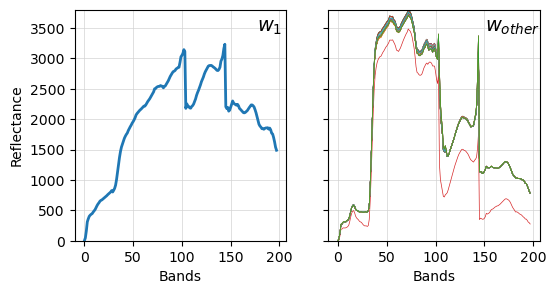

In [10]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(6, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{ax_idx + 1}}}$', fontsize=14, x=0.92, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{{other}}}$', fontsize=14, x=0.87, y=0.87)

plt.savefig('../image_pdfs/jasper_experiment_1_w_overlapped.pdf', bbox_inches='tight')

### Jasper Experiment 2

In [11]:
data_filepath = '../datasets/jasper_region_2.npz'
saved_model_filepath = '../saved_models/jasper_experiment_2/'

In [12]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)

m, n = M.shape

In [13]:
r = n
_lam = 1000
_gamma = 0.001
max_iters = 1000

In [14]:
ini_filepath = saved_model_filepath + f'r{r}_ini.npz'
if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

SONNMF

In [15]:
save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz'

if os.path.exists(save_filepath):
    W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath)
else:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

/Users/waqas/opt/anaconda3/envs/sonnmf/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/waqas/opt/anaconda3/envs/sonnmf/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/waqas/opt/anaconda3/envs/sonnmf/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


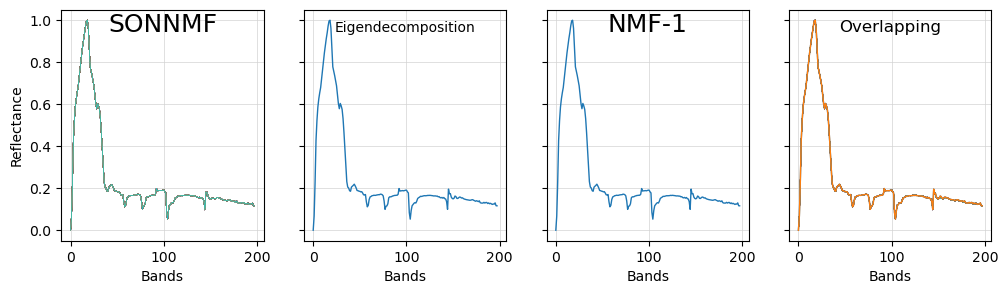

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.ravel()

for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


axs[0].plot(W / np.max(W), linewidth=0.5)
axs[0].set_title('SONNMF', fontsize=18, x=0.5, y=0.87)

w, v = np.linalg.eig(M @ M.T)
axs[1].plot(v[:, 0] / np.max(v[:, 0]), linewidth=1)
axs[1].set_title('Eigendecomposition', fontsize=10, x=0.5, y=0.87)


model = NMF(n_components=1, random_state=42, max_iter=max_iters)
W_NMF = model.fit_transform(X=M)
axs[2].plot(W_NMF / np.max(W_NMF), linewidth=1)
axs[2].set_title('NMF-1', fontsize=18, x=0.5, y=0.87)

axs[3].plot(W / np.max(W), linewidth=0.5)
axs[3].plot(v[:, 0] / np.max(v[:, 0]), linewidth=1)
axs[3].plot(W_NMF / np.max(W_NMF), linewidth=1)
axs[3].set_title('Overlapping', fontsize=12, x=0.5, y=0.87)

plt.savefig('../image_pdfs/jasper_experiment_2_w_comp.pdf', bbox_inches='tight')

### Jasper Experiment 3

In [17]:
data_filepath = '../datasets/jasper_full.npz'
saved_model_filepath = '../saved_models/jasper_experiment_3/'

In [18]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)

m, n = M.shape

In [19]:
r = 20
_lam = 1000000
_gamma = 1000000
max_iters = 1000

In [20]:
ini_filepath = saved_model_filepath + f'r{r}_ini.npz'
if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

Vanilla NMF

In [21]:
save_filepath = saved_model_filepath + f'vanilla_r{r}_it{max_iters}.npz'
if os.path.exists(save_filepath):
    data = np.load(save_filepath)
    W_NMF = data['W']
    H_NMF = data['H']
else:
    model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
    W_NMF = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
    H_NMF = model.components_
    with open(save_filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W_NMF, H=H_NMF)

SONNMF

In [22]:
save_filepath = saved_model_filepath + f'r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz'

if os.path.exists(save_filepath):
    W, H, fscores, gscores, hscores, total_scores = load_results(save_filepath)
else:
    W, H, fscores, gscores, hscores, total_scores = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, gamma=_gamma, itermax=max_iters, W_update_iters=10, early_stop=True, verbose=False)
    save_results(save_filepath, W, H, fscores, gscores, hscores, total_scores)

In [23]:
unique_idxs = [6, 8, 14]
other_idxs = [x for x in range(r) if x not in unique_idxs]

In [24]:
# Energy calculations (%)
unique_labels = ['water', 'tree', 'soil']
for i in range(len(unique_idxs)):
    print(unique_labels[i], (np.linalg.norm(W[:, unique_idxs[i]:unique_idxs[i]+1] @ H[unique_idxs[i]:unique_idxs[i]+1, :], 'fro') / np.linalg.norm(M, 'fro')) * 100)

water 9.111149141970506
tree 54.007042305810145
soil 59.011589954217214


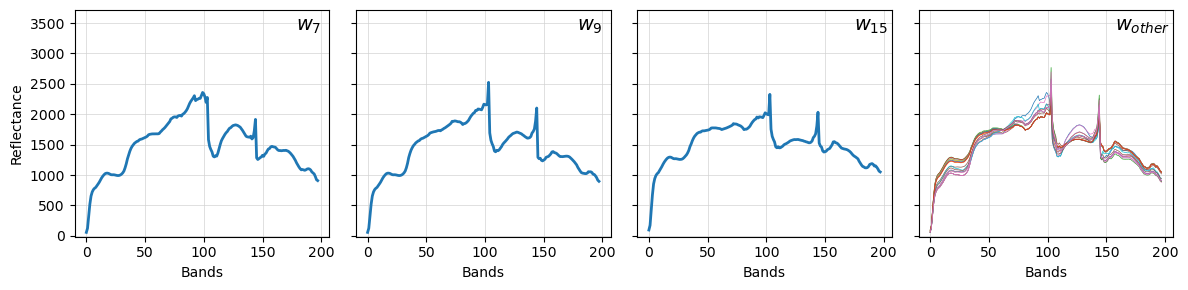

In [25]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, ax_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx + 1}}}$', fontsize=14, x=0.92, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{other}}}$', fontsize=14, x=0.88, y=0.87)

plt.tight_layout()
plt.savefig('../image_pdfs/jasper_experiment_3_w_overlapped.pdf', bbox_inches='tight')

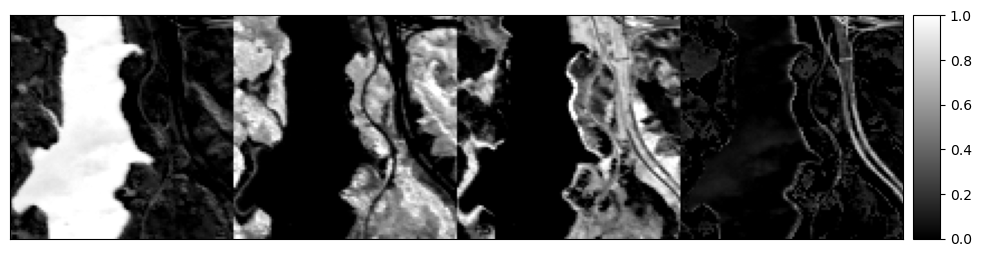

In [26]:
newH = np.vstack((H[unique_idxs, :], H[other_idxs, :].sum(axis=0)))
newH3d = newH.reshape(-1, 100, 100, order='F')
large_mat = np.hstack(newH3d)

fig, ax = plt.subplots(figsize=(12, 3))
img = ax.imshow(large_mat, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../image_pdfs/jasper_experiment_3_h_summed.pdf', bbox_inches='tight')

In [28]:
fns = ['tmp_w.jpg', 'tmp_seph.jpg', 'tmp_combh.jpg', '../image_pdfs/jasper_vanilla.pdf']
plot_and_merge(W_NMF, H_NMF, (100, 100), (33, 6), 16, fns, 2, delete=True)
